In [1]:
!git clone https://github.com/sobhanshukueian/Self-Supervised-Survey.git

Cloning into 'Self-Supervised-Survey'...
remote: Enumerating objects: 647, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 647 (delta 202), reused 191 (delta 84), pack-reused 337
Receiving objects: 100% (647/647), 240.36 KiB | 8.90 MiB/s, done.
Resolving deltas: 100% (438/438), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd Self-Supervised-Survey

/content/Self-Supervised-Survey


# Heatmaps


In [ ]:
!pip install omnixai

In [13]:

import os
import numpy as np
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'


import torch
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.cuda import amp
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import cv2
# Imagenet mean/std
from PIL import Image as PilImage

from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM

# from data.cifar_dataset import train_dataloader, train_val_dataloader, test_dataloader
# from vis import show_batch
from configs import model_config
from utils.utils import LARS, off_diagonal, get_color, get_colors, get_params_groups, LinearClassifier, accuracy, compute_acc, save, set_logging
# from Barlow_model import BarlowTwins
from utils.main_utils import get_optimizer, get_model

In [82]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model, conf, ckpt = get_model("SimSiam", {"Model":""}, False, "", "/content/drive/MyDrive/ablation study/simsiam/run3/weights/last.pt", 3)
model = model.encoder.to(device)
# model.fc.weight.data.normal_(mean=0.0, std=0.01)
# model.fc.bias.data.zero_()
model.eval()

Loading state_dict from /content/drive/MyDrive/ablation study/simsiam/run3/weights/last.pt for fine-tuning...


Sequential(
  (0): ModelBase(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)

In [83]:
linear_classifier = LinearClassifier(model_config["EMBEDDING_SIZE"])
linear_classifier = linear_classifier.to(device)
ckpt = torch.load("/content/drive/MyDrive/ablation study/linear/simsiam/run/weights/last.pt")
state_dict = ckpt['model'].float().state_dict()
model_state_dict = linear_classifier.state_dict()
state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and v.shape == model_state_dict[k].shape}
linear_classifier.load_state_dict(state_dict, strict=False)
del state_dict, model_state_dict

In [84]:
model = nn.Sequential(model, linear_classifier)
model.eval()
model

Sequential(
  (0): Sequential(
    (0): ModelBase(
      (net): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

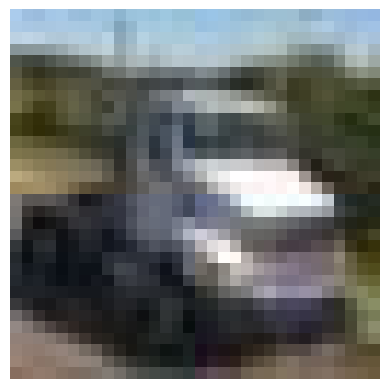


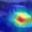
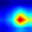

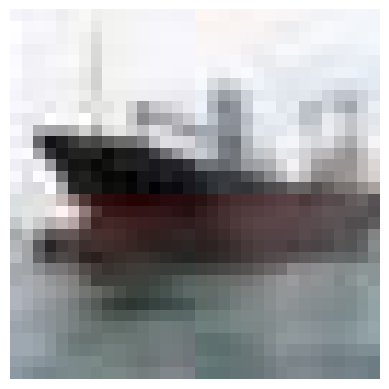


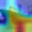
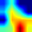

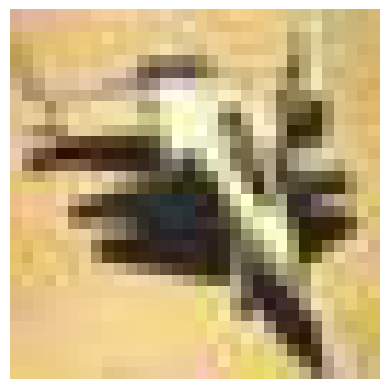


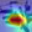
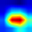

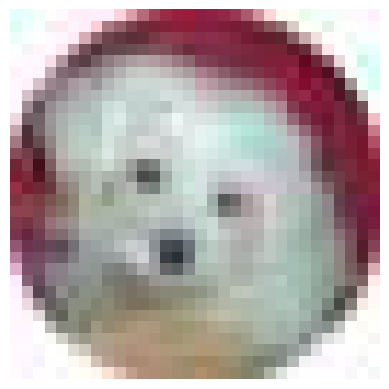


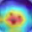
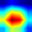

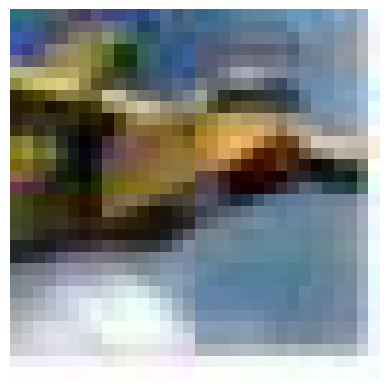


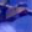

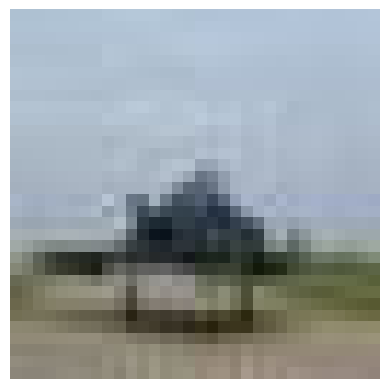


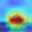
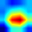

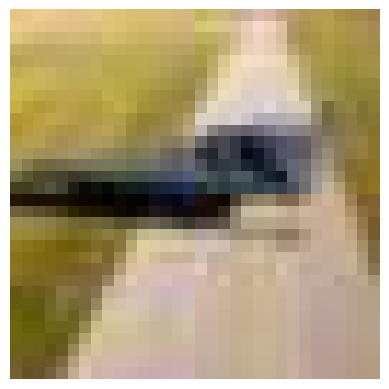


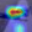
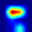

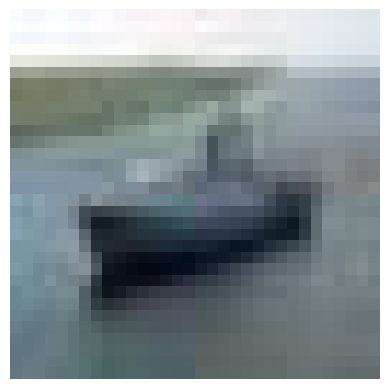


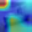
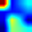

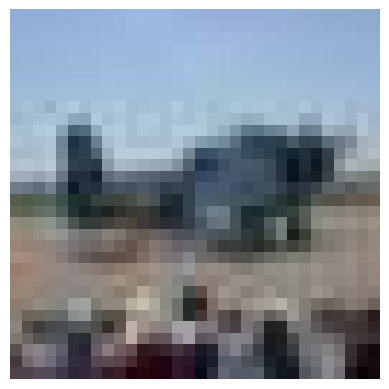


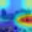
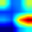

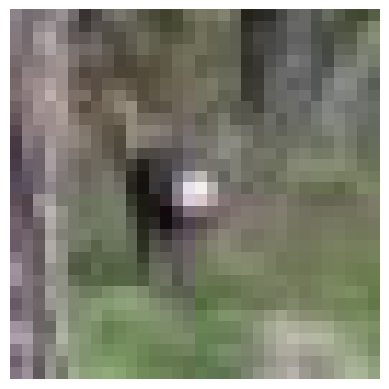


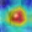
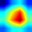

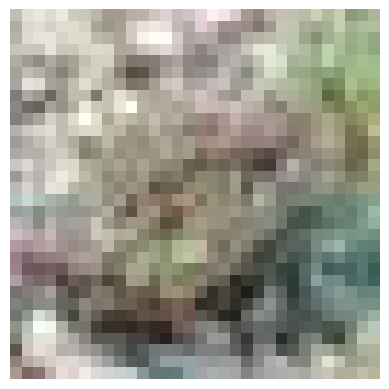


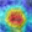
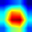

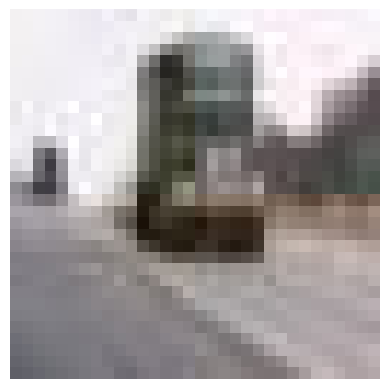


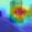
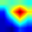

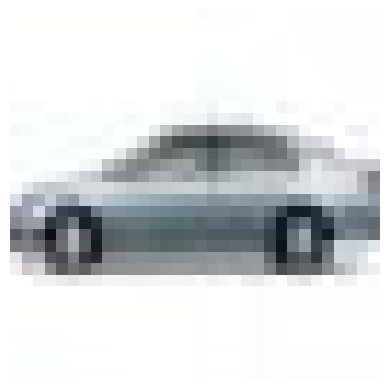


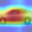
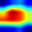

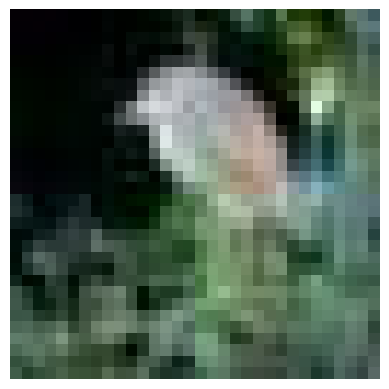


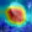
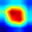

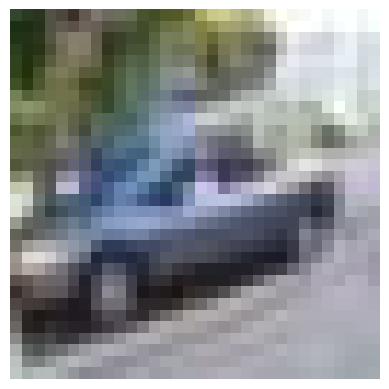


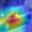
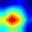

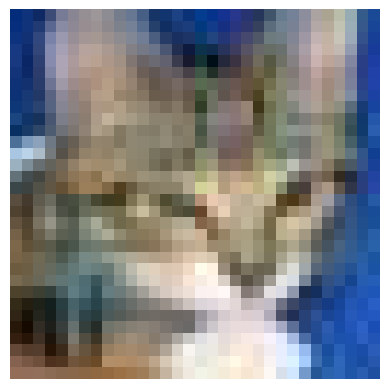


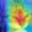
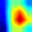

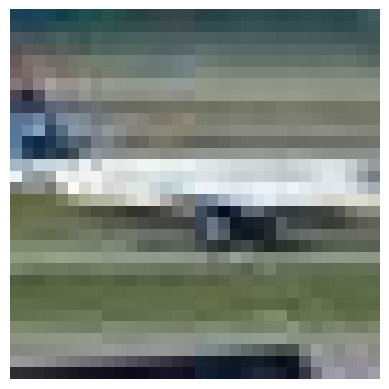


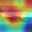
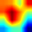

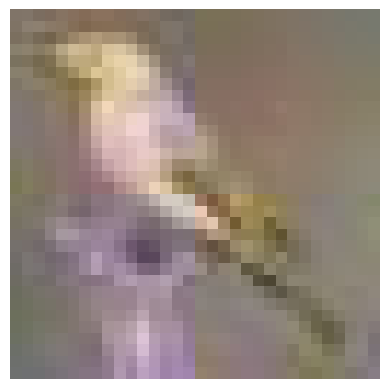


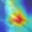
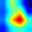

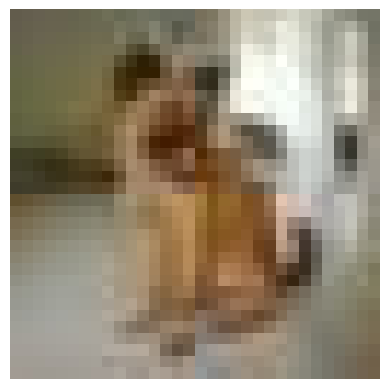


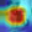
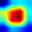

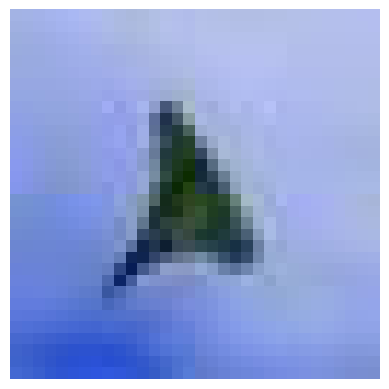


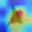
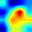

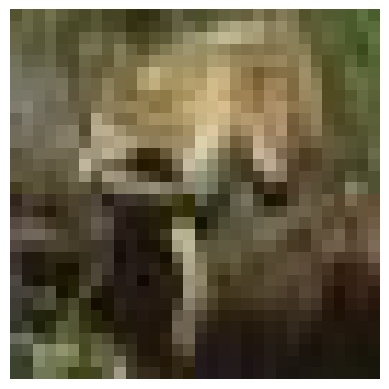


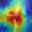
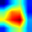

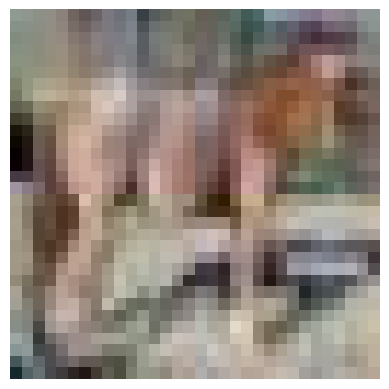


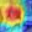
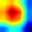

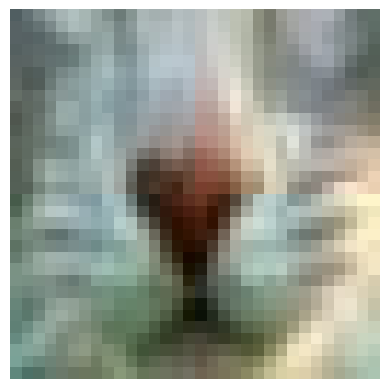


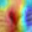
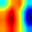

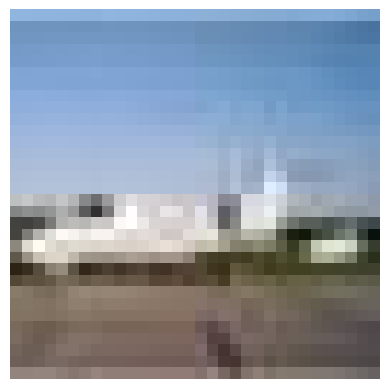


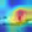
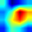

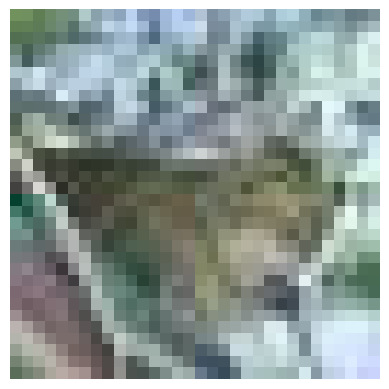


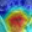
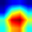

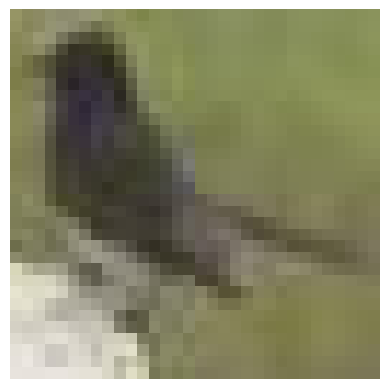


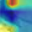
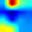

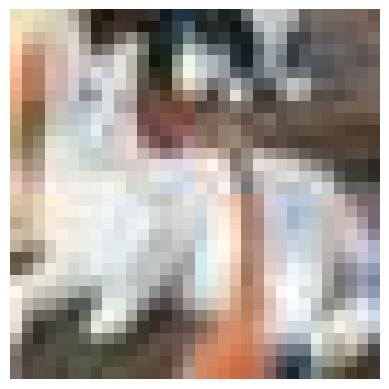


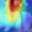
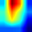

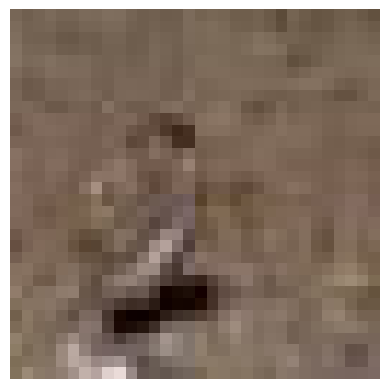


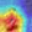
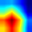

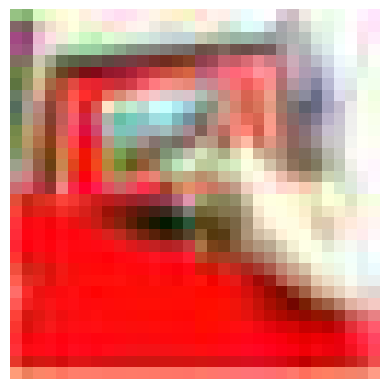


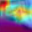
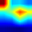

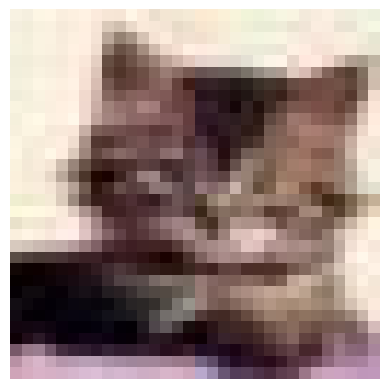


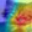
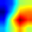

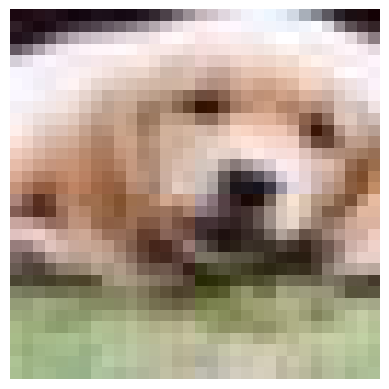


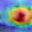
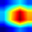

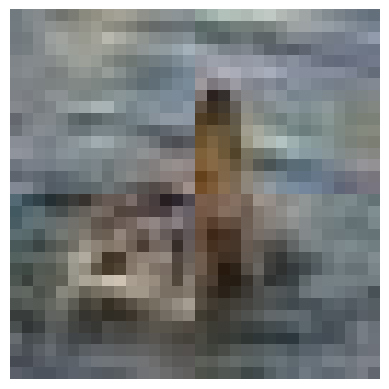


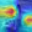
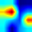

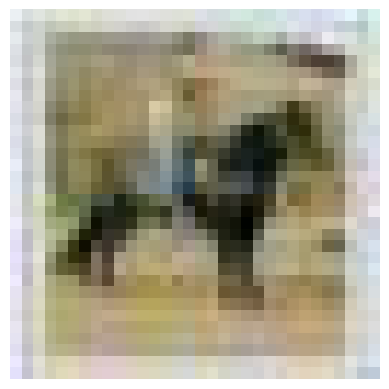

KeyboardInterrupt: ignored

In [85]:
from matplotlib.pyplot import imshow

for image_name in os.listdir("/content/Self-Supervised-Survey/cifar_test_images"):
    transform = transforms.Compose([
        transforms.Resize(40),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
    image = PilImage.open(f"/content/Self-Supervised-Survey/cifar_test_images/{image_name}").convert('RGB')
    # imshow(image)

  # Plot the PIL Image
    plt.imshow(image)
    plt.axis('off')  # Optional: Turn off the axis labels
    plt.show()
    plt.show()

    img = Image(image)

    explainer = GradCAM(
        model=model,
        target_layer= model[0][0].net[6],
        preprocess_function=preprocess
    )
    # Explain the top label
    explanations = explainer.explain(img)
    # xxx = explanations.get_explanations()
    # print(xxx)
    explanations.ipython_plot(index=0 )
        # Plot the PIL Image
    # plt.imshow(xxx[0]['scores'])
    # plt.axis('off')  # Optional: Turn off the axis labels
    # plt.show()
